In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [11]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
trip_from='2017-08-01'
trip_to = '2017-08-07'

temp_stat=calc_temps(trip_from, trip_to)[0]
print(f"TMIN: {temp_stat[0]} F")
print(f"TAVG: {temp_stat[1]} F")
print(f"TMAX: {temp_stat[2]} F")

TMIN: 72.0 F
TAVG: 79.25 F
TMAX: 83.0 F


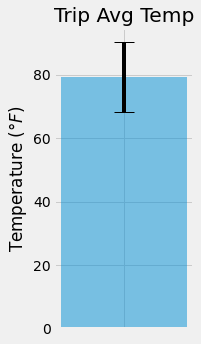

In [12]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_pos = 1
TAVG = temp_stat[1]
error = temp_stat[2] - temp_stat[0]

fig, ax = plt.subplots(figsize = (3,5))
ax.bar(x_pos, TAVG, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Temperature ($\degree F$)')
ax.set_xticks([x_pos])
ax.set_xticklabels([''])
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()




### Daily Rainfall Average

In [13]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

results = session.query(Station.station, func.sum(Measurement.prcp),Station.name, Station.latitude, Station.longitude, Station.elevation).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date>= trip_from).\
            filter(Measurement.date<= trip_to).\
            group_by(Station.station).\
            order_by(func.sum(Measurement.prcp).desc()) .\
            all()
           
rainfall_summary_station = pd.DataFrame(results, columns=['Station', 'Precipitation Sum', 'Station Name', 'Latitude', 'Longitude', 'Elevation'])
rainfall_summary_station


,Station,Precipitation Sum,Station Name,Latitude,Longitude,Elevation
0,USC00516128,0.36,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00514830,0.22,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,USC00519281,0.06,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,USC00519397,0.04,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
4,USC00519523,0.00,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


In [14]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [15]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
format = "%Y-%m-%d"
dt_start = dt.datetime.strptime(start_date, format)
dt_end = dt.datetime.strptime(end_date, format)

normals=[]
while dt_start<=dt_end:
    trip_day = {}
    trip_day['Date'] = dt_start
    res=daily_normals(dt_start.strftime("%m-%d"))[0]
    trip_day['MIN Temp'] = res[0]
    trip_day['AVG Temp'] = round(res[1],2)
    trip_day['MAX Temp'] = res[2]
    dt_start += dt.timedelta(days=1) 
    normals.append(trip_day)
print(normals)    



[{'Date': datetime.datetime(2017, 8, 1, 0, 0), 'MIN Temp': 67.0, 'AVG Temp': 75.54, 'MAX Temp': 83.0}, {'Date': datetime.datetime(2017, 8, 2, 0, 0), 'MIN Temp': 68.0, 'AVG Temp': 75.6, 'MAX Temp': 84.0}, {'Date': datetime.datetime(2017, 8, 3, 0, 0), 'MIN Temp': 70.0, 'AVG Temp': 76.61, 'MAX Temp': 85.0}, {'Date': datetime.datetime(2017, 8, 4, 0, 0), 'MIN Temp': 69.0, 'AVG Temp': 76.71, 'MAX Temp': 84.0}, {'Date': datetime.datetime(2017, 8, 5, 0, 0), 'MIN Temp': 69.0, 'AVG Temp': 76.15, 'MAX Temp': 82.0}, {'Date': datetime.datetime(2017, 8, 6, 0, 0), 'MIN Temp': 67.0, 'AVG Temp': 76.25, 'MAX Temp': 83.0}, {'Date': datetime.datetime(2017, 8, 7, 0, 0), 'MIN Temp': 71.0, 'AVG Temp': 77.16, 'MAX Temp': 83.0}]


In [16]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals)

trip_df.set_index(['Date'], inplace=True)  
trip_df

,MIN Temp,AVG Temp,MAX Temp
Date,,,
2017-08-01,67.0,75.54,83.0
2017-08-02,68.0,75.60,84.0
2017-08-03,70.0,76.61,85.0
2017-08-04,69.0,76.71,84.0
2017-08-05,69.0,76.15,82.0
2017-08-06,67.0,76.25,83.0
2017-08-07,71.0,77.16,83.0


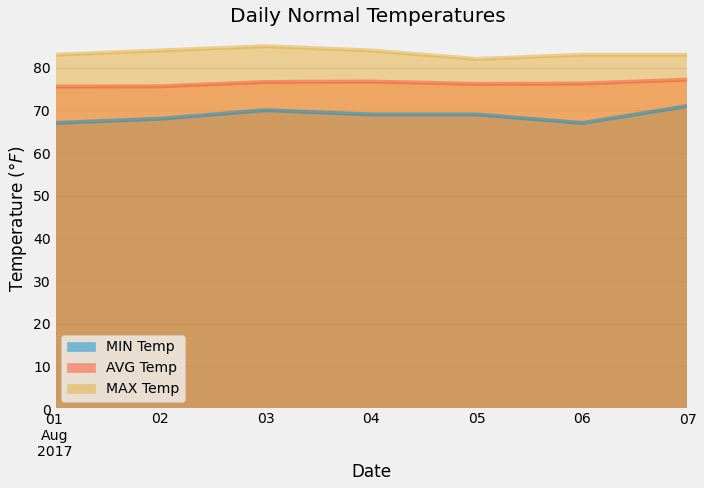

In [17]:
# Plot the daily normals as an area plot with `stacked=False`
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize = (10, 7))
trip_df.plot.area(ax = ax, stacked = False)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($\degree F$)')
ax.set_title('Daily Normal Temperatures ')

ax.grid(True)


plt.tight_layout()
plt.show()

## Close Session

In [18]:
session.close()